In [128]:
import pandas as pd
from joblib import dump, load  # for saving/loading
from normalize import normalize
import numpy as np

In [129]:
file = "RawCSV/Injected/GFP/250310_250212GFPM1DLC_Resnet50_2024-BehavioralJul6shuffle3_snapshot_300_filtered.csv"
sound_data_path = "RawCSV/Injected/GFP/250310_250212GFPM1_lowcut.csv"
output_csv_path = "Merged/Injected/250310_250212GFPM1_MERGED.csv" 
filtered_df_path = file
## REMINDER: YOU NEED TO HAVE IT IN THE MERGED DATA FRAME FORMAT

# Load the data
filtered_df = pd.read_csv(file, header=[1, 2])
filtered_df.columns = ['_'.join(col).strip() for col in filtered_df.columns.values]
if 'Frames' not in filtered_df.columns:
    filtered_df = filtered_df.rename(columns={filtered_df.columns[0]: 'Frames'})

# print(filtered_df.columns)
normalized_data = normalize(filtered_df, 'Anchor_L', 'Anchor_R', midpoint=True, reference_p1_2='Anchor_R')

# 2. DLC raw output: Columns that end with '_x', '_y', or '_likelihood'
DLC_raw_output = normalized_data.filter(regex='(_x|_y|_likelihood)$')

DLC_raw_output.ffill(inplace=True)  # Forward fill to handle NaN values
##

"""
Take 3 files with you: 
. This one: example.ipynb
. where the normalze function is: normalize.py
. where the MLP model lives: mlp_pipeline.joblib
"""

/var/folders/st/m6jq2k2x1ng9w38x64s0ybqc0000gn/T/ipykernel_28415/3481932164.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DLC_raw_output.ffill(inplace=True)  # Forward fill to handle NaN values


'\nTake 3 files with you: \n. This one: example.ipynb\n. where the normalze function is: normalize.py\n. where the MLP model lives: mlp_pipeline.joblib\n'

In [130]:
# Load the joblib file
model = load("mlp_pipeline.joblib")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


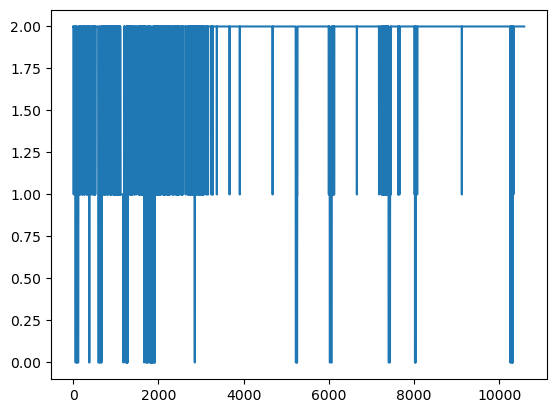

In [131]:
out = model.predict(DLC_raw_output)

# Save the predictions to a CSV file

import matplotlib.pyplot as plt

plt.plot(out)
#pd.DataFrame(out, columns=['MLP prediction']).to_csv('mlp_predictions.csv', index=False)

NOTES (From Ryan):
1. This code is a combination of Tom's classifier and the sound processing code.
2. I used a process_sound_group function to process the sound data and group it by frames.
3. Since there were multiple sound bursts with different sides (left/1 or right/2) in the same second playing ultrasound (e.g., 18000 Hz), 
I used a median to determine the dB level and pitches for each group and just duplicated it.
[It was weird converting seconds to frames because seconds were in 60 fps, but I just used the floor function to get the frame number, which is
an integer. But because of using floor, that meant there were duplicate frames in the sound data, so I had to group by frames and pick the median.]
4. Then I merged the processed sound data with the filtered CSV data, and added the OUTPUT_LABEL to save the final output to a CSV file
5. It's a good idea to use plt.plot(out) above to visualize the output of the MLP model (to make sure it looks reasonable).

In [ ]:
# Assume OUTPUT_LABEL is a predefined vector with the same length as the final merged frames
# OUTPUT_LABEL = [...]  # This should be defined before running the script
OUTPUT_LABEL = out  # Assuming 'out' is the output from the MLP model

# --- PART 1: Process sound data ---
sound_df = pd.read_csv(sound_data_path, header=0, names=["x_raw", "Pitches_L", "dB_L", "Pitches_R", "dB_R"])
sound_df["Frames"] = np.floor(sound_df["x_raw"] * 60).astype(int)

def process_sound_group(group):
    left_18000 = (group["Pitches_L"] == 18000).any()
    right_18000 = (group["Pitches_R"] == 18000).any()
    
    if left_18000 or right_18000:
        if left_18000:
            median_row = group[group["Pitches_L"] == 18000].median(numeric_only=True)
            pitches_val = 18000
            db_val = median_row["dB_L"]
        else:
            median_row = group[group["Pitches_R"] == 18000].median(numeric_only=True)
            pitches_val = 18000
            db_val = median_row["dB_R"]
    else:
        median_left_db = group["dB_L"].median()
        median_right_db = group["dB_R"].median()
        if median_left_db >= median_right_db:
            pitches_val = group["Pitches_L"].median()
            db_val = median_left_db
        else:
            pitches_val = group["Pitches_R"].median()
            db_val = median_right_db
    
    return pd.DataFrame({
        "Frames": [group.name],
        "Pitches_combined": [pitches_val],
        "dB_combined": [db_val]
    })

sound_processed = sound_df.groupby("Frames", group_keys=False).apply(process_sound_group)

# --- PART 2: Process filtered CSV ---
filtered_df = pd.read_csv(filtered_df_path, header=[1, 2])
filtered_df.columns = ['_'.join(col).strip() for col in filtered_df.columns.values]

if 'Frames' not in filtered_df.columns:
    filtered_df = filtered_df.rename(columns={filtered_df.columns[0]: 'Frames'})

# --- PART 3: Merge sound and filtered data ---
merged_df = pd.merge(sound_processed, filtered_df, on='Frames', how='outer')

# --- PART 4: Add and process OUTPUT_LABEL ---
def add_state_labels(df, output_label):
    """Adds both the numeric state and descriptive state_label columns"""
    # State mapping dictionary
    state_map = {
        0: "not flying",
        1: "transition",
        2: "flying"
    }
    
    # Convert output_label to list if it's a NumPy array
    if hasattr(output_label, 'tolist'):
        output_label = output_label.tolist()
    
    # --- Handle length mismatch ---
    if len(output_label) < len(df):
        last_label = output_label[-1]  # Get the last label
        extension = [last_label] * (len(df) - len(output_label))
        output_label_extended = output_label + extension
        print(f"Warning: Extended OUTPUT_LABEL from {len(output_label)} to {len(df)} using last value ({last_label})")
        output_label = output_label_extended
    elif len(output_label) > len(df):
        raise ValueError(f"OUTPUT_LABEL (len={len(output_label)}) is longer than DataFrame (len={len(df)})")
    
    # Add the columns
    df["state"] = output_label[:len(df)]  # Ensure no overflow
    df["state_label"] = [state_map.get(x, "unknown") for x in df["state"]]
    
    return df

# Apply the function to add both columns
merged_df = add_state_labels(merged_df, OUTPUT_LABEL)

# --- PART 5: Reorder columns ---
sound_cols = ['Pitches_combined', 'dB_combined']
state_cols = ['state', 'state_label']  # Keep these together
filtered_cols = [col for col in filtered_df.columns if col != 'Frames']

ordered_cols = ['Frames'] + sound_cols + state_cols + filtered_cols
final_df = merged_df[ordered_cols].sort_values('Frames').reset_index(drop=True)

# --- PART 6: Save Output ---
final_df.to_csv(output_csv_path, index=False)
print(f"Output saved to {output_csv_path}")

/var/folders/st/m6jq2k2x1ng9w38x64s0ybqc0000gn/T/ipykernel_28415/1131543683.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sound_processed = sound_df.groupby("Frames", group_keys=False).apply(process_sound_group)


Output saved to Merged/Injected/250310_250212GFPM1_MERGED.csv
